## Let's load in the data and limit the time period

In [1]:
# This command allows plots to appear in the jupyter notebook.
%matplotlib inline  
# Import the pandas package and load the cleaned json file into a dataframe called df_input.
import pandas as pd
df_input = pd.read_json('JEOPARDY_QUESTIONS1_cleaned.json')
# Division is float division
from __future__ import division
# Let's convert air_date to date/time, rather than a string.
df_input['air_date'] = pd.to_datetime(df_input['air_date'], yearfirst= True)
# Let's only look at the years where the data is well-sampled.
df1 = df_input[(df_input['air_date'] >= '01-01-1997') & (df_input['air_date'] <= '12-31-2000')]
df2 = df_input[(df_input['air_date'] >= '01-01-2004') & (df_input['air_date'] <= '12-31-2011')]
# Create final dataframe with a question in each row.
df = pd.concat([df1, df2])
# Adjust view.
pd.set_option('max_colwidth', 300)

In [2]:
# Create new dataframe with only states as answers.
list_of_states = ['Alabama','Alaska','Arizona','Arkansas','California', 
                  'Colorado','Connecticut', 'Delaware', 'Florida','Georgia',
                  'Hawaii','Idaho','Illinois','Indiana', 'Iowa', 'Kansas',
                  'Kentucky', 'Louisiana', 'Maine', 'Maryland', 'Massachusetts',
                  'Michigan','Minnesota','Mississippi', 'Missouri','Montana','Nebraska', 
                  'Nevada','New Hampshire', 'New Jersey','New Mexico', 'New York',
                  'North Carolina', 'North Dakota','Ohio','Oklahoma', 'Oregon',
                  'Pennsylvania', 'Rhode Island','South Carolina', 'South Dakota',
                  'Tennessee','Texas','Utah','Vermont', 'Virginia', 'Washington', 
                  'West Virginia', 'Wisconsin', 'Wyoming']
state_answers = df[df['answer'].isin(list_of_states)]
count_state_answers = state_answers.answer.value_counts()
state_data = pd.DataFrame(count_state_answers)
state_data.columns = ['total_count']
state_data.head()

,total_count
California,133
Hawaii,116
Texas,116
Alaska,115
Florida,113


## Wikipedia article word counts don't trace Jeopardy popularity

In order to answer the question of why some states appear as Jeopardy answers more frequently than others I decided to use [Wikipedia](https://www.wikipedia.org/) as a proxy for popularity. I first tried looking into word counts on a state's Wikipedia article. I was thinking that popular states might have longer articles written about them. Let's see what that shows.

To investigate Wikipedia articles, I used a [python wrapper for the Wikipedia API](https://wikipedia.readthedocs.io/en/latest/) using the command `pip install wikipedia` to install it.

In [3]:
import wikipedia
print wikipedia.search("California")

[u'California', u'California City, California', u'Baja California Peninsula', u'Outline of California', u'History of California', u'California Gold Rush', u'Northern California', u'Governor of California', u'California English', u'Indigenous peoples of California']


In [4]:
print wikipedia.summary("California")[0:150]

California (/ˌkælᵻˈfɔːrnjə, -ni.ə/ KAL-ə-FORN-yə, KAL-ə-FORN-ee-ə) is the most populous state in the United States and the third most extensive by are


In [5]:
print wikipedia.search("Georgia")

[u'Georgia', u'Georgia (country)', u'University of Georgia', u'President of Georgia', u'Kingdom of Georgia', u'History of Georgia (country)', u'Georgia (U.S. state)', u'Georgia Dome', u'Georgia Southern\u2013Georgia State rivalry', u'Foreign relations of Georgia']


In [6]:
# The following line gives an error because of ambiguity between 
# Georgia-the U.S. state, Georgia-the country, and others.
#print wikipedia.summary("Georgia")[0:150]

So, searching for information on "Georgia", "Washington", "New York" will cause an error because of ambiguity. 
I used the [links to states on Wikipedia](https://en.wikipedia.org/wiki/List_of_states_and_territories_of_the_United_States) to figure out which states could cause problems and created a new list of states for my Wikipedia search.
    

In [7]:
# Make a copy of the the original list of states and create a list `list_of_states_wiki` to use to search Wikipedia.
list_of_states_wiki = list(list_of_states)
list_of_states_wiki.remove('Georgia')
list_of_states_wiki.append('Georgia (U.S. state)')
list_of_states_wiki.remove('New York')
list_of_states_wiki.append('New York (state)')
list_of_states_wiki.remove('Washington')
list_of_states_wiki.append('Washington (state)')

In [8]:
# Check the list.
list_of_states_wiki.sort()
list_of_states_wiki[0:10]

['Alabama',
 'Alaska',
 'Arizona',
 'Arkansas',
 'California',
 'Colorado',
 'Connecticut',
 'Delaware',
 'Florida',
 'Georgia (U.S. state)']

In [9]:
# Grab all Wikipedia state articles and count the number of words in the article. 
# Make sure the word "state" is in the summary.
# This loop can take awhile...
state_summary = {}
state_word_count = {}
for state in list_of_states_wiki:
    summary = wikipedia.summary(state)[0:200]
    state_summary[state] = summary
    if 'state' not in summary: 
        print "Check state:", state
    statepage = wikipedia.WikipediaPage(state)
    state_word_count[state] = len(statepage.content.split(' '))

In [10]:
# Change state names back to original to combine with the `state_data` dataframe.
state_word_count['Washington'] = state_word_count.pop("Washington (state)")
state_word_count['Georgia'] = state_word_count.pop("Georgia (U.S. state)")
state_word_count['New York'] = state_word_count.pop("New York (state)")

In [11]:
# Create new dataframe to combine with `state_data` dataframe.
df_state_word_count = pd.DataFrame.from_dict(state_word_count, orient = 'index', dtype = float)
df_state_word_count.columns = ['wiki_word_count']
# Combine word counts to `state_data` dataframe.
state_data = state_data.join(df_state_word_count, how = 'outer')

Let's plot the number of words in a Wikipedia article and the number of times a state has appeared on Jeopardy to see if there's a relationship.

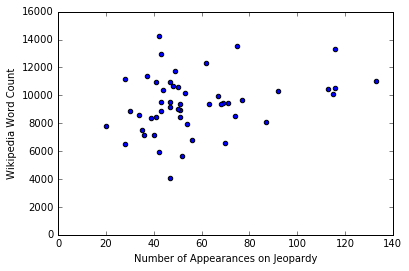

In [12]:
ax = state_data.plot(x = 'total_count', y = 'wiki_word_count', kind = 'scatter', ylim= (0, 16000))
ax.set_xlabel('Number of Appearances on Jeopardy')
ax.set_ylabel('Wikipedia Word Count');

Hmmm... This is not as useful as I'd like it to be. Let's calculate the [correlation coefficient](https://docs.scipy.org/doc/scipy-0.16.0/reference/generated/scipy.stats.pearsonr.html) for now. I don't think it will be very useful, but perhaps we can use it to compare to another tracer of popularity.

In [13]:
from scipy.stats import pearsonr
rwc, pvaluewc = pearsonr(state_data['total_count'], state_data['wiki_word_count'])
print "p_wc = ", pvaluewc
print "r_wc = ", rwc

p_wc =  0.0474096983668
r_wc =  0.281801645529


## Using Wikipedia page views to trace Jeopardy popularity

Rather than Wikipedia word count, perhaps an alternative indicator of popularity is *Wikipedia page views*. Luckily there is [another python tool which uses Wikipedia's API to get page views](https://github.com/mediawiki-utilities/python-mwviews
). To install it, use `pip install mwviews`

In [14]:
# Import the Wikipedia tool
from mwviews.api import PageviewsClient
p = PageviewsClient()

In [15]:
# Here's a fun command that let's you track the current trends on Wikipedia.
# If you leave off year, month, and day, the returned result will be for `today`.

# One of my favorite American traditions.
p.top_articles('en.wikipedia', limit = 3 , year = 2015, month = 11, day = 26)

[{u'article': u'Main_Page', u'rank': 1, u'views': 17993586},
 {u'article': u'Special:Search', u'rank': 2, u'views': 2481439},
 {u'article': u'Thanksgiving', u'rank': 3, u'views': 605476}]

In [16]:
# One of my least favorite American traditions.
p.top_articles('en.wikipedia', limit = 3 , year = 2015, month = 11, day = 27)

[{u'article': u'Main_Page', u'rank': 1, u'views': 17705131},
 {u'article': u'Special:Search', u'rank': 2, u'views': 2398938},
 {u'article': u'Black_Friday_(shopping)', u'rank': 3, u'views': 444341}]

I'll use the most recent year, 2016, to count the number of page views on Wikipedia over the course of a year for each state. I would have liked to compare my dataset which runs from 1997-2000 and 2004-2011 to the same timeframe on Wikipedia. Unfortunately, the Wikipedia API only seems to go back to about 2015. 

In [17]:
# Here are the results for Arizona for 2016. 
p.article_views('en.wikipedia', ['Arizona'], 
                granularity='monthly', start='2016010100', end='2016123100')

{datetime.datetime(2016, 1, 1, 0, 0): {'Arizona': 131409},
 datetime.datetime(2016, 2, 1, 0, 0): {'Arizona': 125917},
 datetime.datetime(2016, 3, 1, 0, 0): {'Arizona': 151741},
 datetime.datetime(2016, 4, 1, 0, 0): {'Arizona': 174710},
 datetime.datetime(2016, 5, 1, 0, 0): {'Arizona': 123279},
 datetime.datetime(2016, 6, 1, 0, 0): {'Arizona': 112169},
 datetime.datetime(2016, 7, 1, 0, 0): {'Arizona': 101361},
 datetime.datetime(2016, 8, 1, 0, 0): {'Arizona': 106251},
 datetime.datetime(2016, 9, 1, 0, 0): {'Arizona': 112453},
 datetime.datetime(2016, 10, 1, 0, 0): {'Arizona': 120101},
 datetime.datetime(2016, 11, 1, 0, 0): {'Arizona': 137877},
 datetime.datetime(2016, 12, 1, 0, 0): {'Arizona': 114489}}

In [18]:
# The Wikipedia tool doesn't automatically calculate page views annually. 
# Instead I'll just sum up the data for each month to get the results for a year.
state_views = {}
for state in list_of_states_wiki:
    views = p.article_views('en.wikipedia', [state], 
                        granularity='monthly', start='2016010100', end='2016123100')
    total_views = 0
    for view in views:
        key_state_name = views[view].keys()
        total_views +=views[view][key_state_name[0]]
    state_views[state] = total_views

In [19]:
# Combine new state view data into state_data dataframe.
state_views['Washington'] = state_views.pop("Washington (state)")
state_views['Georgia'] = state_views.pop("Georgia (U.S. state)")
state_views['New York'] = state_views.pop("New York (state)")
df_state_views = pd.DataFrame.from_dict(state_views, orient = 'index', dtype = float)
df_state_views.columns = ['wiki_views']
state_data = state_data.join(df_state_views, how = 'outer')

In [20]:
state_data.head()

,total_count,wiki_word_count,wiki_views
Alabama,37,11349.0,1340664.0
Alaska,115,10073.0,2631738.0
Arizona,63,9391.0,1511757.0
Arkansas,34,8607.0,1050623.0
California,133,11028.0,4985559.0


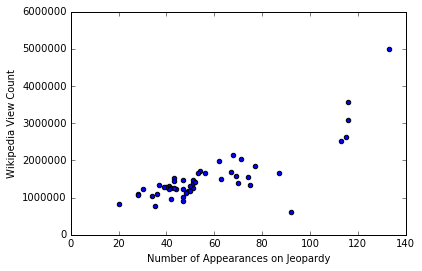

In [21]:
ax = state_data.plot(x = 'total_count', y = 'wiki_views', kind = 'scatter')
ax.set_xlabel('Number of Appearances on Jeopardy')
ax.set_ylabel('Wikipedia View Count');

Oooooh!  Look at that trend! Popular states on Wikipedia searches are also popular states on Jeopardy!

In [22]:
# Calculate the relationship between Jeopardy counts and wikipedia views.
rwv, pvaluewv = pearsonr(state_data['total_count'], state_data['wiki_views'])
print "p_wv = ", pvaluewv
print "r_wv = ", rwv

p_wv =  8.77710298901e-13
r_wv =  0.811548212639


In [23]:
# Print numbers again for Jeopardy counts and wikipedia article word counts.
print "p_wc = ", pvaluewc
print "r_wc = ", rwc

p_wc =  0.0474096983668
r_wc =  0.281801645529


Looks good. Remember that the closer the Pearson correlation coeffecient is to +1, the more positively correlated the two variables are.

However, looking back at the plot, there is an odd outlier. Let's take a look at that next.

## New York City or New York State? (or How to Fix an Outlier)

What is that odd outlier located at 90 Jeopardy appearances and under 1,000,000 Wikipedia views? If the number of wikipedia views is "correct", then it should only have appeared on Jeopardy about 40 times.

In [24]:
# What is that outlier with total_count > 90, but wiki_views <1,000,000
state_data[(state_data['total_count']>90) & (state_data['wiki_views']<1000000)]

,total_count,wiki_word_count,wiki_views
New York,92,10322.0,613533.0


Hmmm.... that's odd. I wonder if the fact that "New York" can sometimes refer to the city or the state is the reason it is an outlier.  (By the way, the proper name for the city is ["City of New York"](https://en.wikipedia.org/wiki/New_York_City).) Let's see if Jeopardy sometimes uses an answer of "New York" when asking about the city. Are about half of these 92 "New York" questions really about the city of New York?

In [25]:
# Find questions where the answer is "New York" and the category contains the word "city."
df[((df['answer']=='New York') & (df['category'].str.contains('CIT')))]

,air_date,answer,category,question,round,show_number,value
170157,1999-03-10,New York,SPORTS HOME CITIES,The WNBA'sLiberty,Jeopardy!,3348,1400.0
147556,2011-03-03,New York,TV CITY SETTINGS,"""Castle""",Double Jeopardy!,6099,1600.0
203523,2011-11-28,New York,A TALE OF ONE CITY,"Jay McInerney's ""Bright Lights, Big City""",Double Jeopardy!,6256,800.0
45161,2010-11-24,New York,"BRIGHT LIGHTS, BIG CITY",This city is the brightest area along the East Coast,Jeopardy!,6028,200.0
46877,2009-05-12,New York,CITIES' NEWER NAMES,New Amsterdam,Jeopardy!,5692,600.0


In [26]:
# Find questions where the answer is "New York" and the question contains the word "city."
df[((df['answer']=='New York') & (df['question'].str.contains('cit')))]

,air_date,answer,category,question,round,show_number,value
123888,1997-12-30,New York,TRANSPORTATION,"This city's subway system, made up of the IRT, BMT & IND, has 238 route miles & 469 stations",Jeopardy!,3072,400.0
10777,2008-04-08,New York,A HOST OF GHOSTS,The ghost of impresario David Belasco is said to haunt the theatre named for him on West 44th St. in this city,Jeopardy!,5437,400.0
130911,2005-05-11,New York,PRESIDENTS,"In April 1789 Washington left Mount Vernon, going to this city to head the new governent",Jeopardy!,4773,200.0
148356,2010-04-27,New York,ZOMBIELAND,"& they thought alligators were bad! In 1984's ""C.H.U.D."" zombies haunt this city's sewer system",Jeopardy!,5907,400.0
150545,2008-12-04,New York,STREETCAR,"Beginning service in 1832, this city's first streetcar ran along Bowery Street",Jeopardy!,5579,600.0
161170,2006-07-03,New York,THE U.S. CENSUS,"This city has the largest Hispanic, Asian & African-American populations in the U.S.",Double Jeopardy!,5036,400.0
204556,2011-10-20,New York,ACTING HURT,"John Hurt reprised the role of Quentin Crisp for 2009's ""An Englishman in"" this U.S. city",Double Jeopardy!,6229,1600.0
207097,2011-12-28,New York,UNCOMMON BONDS,"J. Max Bond Jr., who helped design the National September 11 Memorial, was a 1980-86 member of this city's Planning Commission",Jeopardy!,6278,200.0
208353,2006-11-15,New York,AROUND THE U.S.A.,"""I love"" this city, America's biggest metropolis--doesn't everyone?",Jeopardy!,5103,400.0
42784,2010-03-29,New York,MIDDLE INITIAL V.,"John V. Lindsay was mayor of this city in the turbulent '60s & '70s, first as a Republican & then as a Democrat",Jeopardy!,5886,200.0


In [27]:
# Aha! So some New York city answers did sneak into my state-only dataframe. How many?
print df[((df['answer']=='New York') & (df['category'].str.contains('CIT')))]['answer'].count()
print df[((df['answer']=='New York') & (df['question'].str.contains('cit')))]['answer'].count()

5
13


Since one of the questions appears in both datasets, the total count of incorrectly counted New York state answers is 17. I need about 20 more to move the New York point closer to the trend. Let's see if I can find them among the remaining New York questions, if I also exclude clues where "state" is in the category or question.

In [28]:
# Find questions where "New York" is the answer, 
# but "city" or "state" don't appear in the question
# and "CITY" or "STATE" don't appear in the category.
df[(df['answer']=='New York') & (df['question'].str.contains('cit')==False)
   & (df['category'].str.contains('CIT')==False)
  & (df['question'].str.contains('state')==False)
  & (df['category'].str.contains('STATE')==False)]

,air_date,answer,category,question,round,show_number,value
106573,1998-03-02,New York,MUSICAL GEOGRAPHY,"""Start spreading the news"", Ol' Blue Eyes made it here",Jeopardy!,3116,800.0
61074,1998-11-11,New York,THE 13 COLONIES,"Under the Treaty of Breda, the Dutch gave up New Netherland, which the British renamed this",Double Jeopardy!,3263,400.0
102164,2004-04-16,New York,QUARTER BACKS,A gift from France unveiled in 1886,Jeopardy!,4525,400.0
126630,2009-02-20,New York,HOME BOYS,Knickerbockers,Double Jeopardy!,5635,800.0
131466,2006-04-04,New York,GEOGRAPHIC CINEMA,"1931:""Sidewalks of ___""",Jeopardy!,4972,800.0
139200,2011-02-23,New York,THE 13 COLONIES,"Under the Treaty of Breda, the Dutch gave up New Netherland to the British, who renamed it this in 1664",Double Jeopardy!,6093,400.0
146113,2006-03-28,New York,GODZILLA,"Apparently bored with his old conquests, in the 1998 version, Godzilla is intent on destroying this metropolis",Double Jeopardy!,4967,800.0
15213,2008-02-27,New York,EARLY AMERICA,The British took New Netherland & New Amsterdam from the Dutch in 1664 & renamed them both this,Jeopardy!,5408,200.0
152854,2011-05-03,New York,HERE LIES...,Boss Tweed,Double Jeopardy!,6142,1200.0
160620,2006-12-18,New York,"'ALLO, GOVERNOR",In office from 1995:George Pataki,Double Jeopardy!,5126,400.0


A few questions jump out at me as referring to New York city rather than New York state. 

In [29]:
df[(df['answer']=='New York') & (df['question'].str.contains('Godzilla'))]

,air_date,answer,category,question,round,show_number,value
146113,2006-03-28,New York,GODZILLA,"Apparently bored with his old conquests, in the 1998 version, Godzilla is intent on destroying this metropolis",Double Jeopardy!,4967,800.0


In [30]:
df[(df['answer']=='New York') & (df['question'].str.contains('Sidewalks'))]

,air_date,answer,category,question,round,show_number,value
131466,2006-04-04,New York,GEOGRAPHIC CINEMA,"1931:""Sidewalks of ___""",Jeopardy!,4972,800.0


In [31]:
df[(df['answer']=='New York') & (df['question'].str.contains('Tweed'))]

,air_date,answer,category,question,round,show_number,value
152854,2011-05-03,New York,HERE LIES...,Boss Tweed,Double Jeopardy!,6142,1200.0


In [32]:
df[(df['answer']=='New York') & (df['question'].str.contains('Bagdad'))]

,air_date,answer,category,question,round,show_number,value
192035,2011-12-06,New York,THE STORY OF O. HENRY,"In 1910 O. Henry died in this ""Bagdad on the Subway"", the setting for many of his stories",Double Jeopardy!,6262,2000.0


In [33]:
df[(df['answer']=='New York') & (df['question'].str.contains('Fire'))]

,air_date,answer,category,question,round,show_number,value
64453,2009-07-08,New York,TO THE LIGHTHOUSE,"Fire Island Light,Buffalo Light",Jeopardy!,5733,400.0


That only comes to about 5 more questions. 

So far we've looked at questions where the answer is "New York" and 
* the question or category contains "city"

or

* the question/category does NOT contain "city" or "state".

To summarize, I found that about 22 (from 17+5) questions should be removed from the count for New York state. That gives a new total of ...

In [34]:
92-22

70

Let's update the dataframe with New York's new value. Then we can see how the correlation coefficient changes. 

In [35]:
# Update value for New York.
state_data.set_value('New York', 'total_count', 70);

In [36]:
# Calculate the relationship between Jeopardy counts and wikipedia views.
rwvNEW, pvaluewvNEW = pearsonr(state_data['total_count'], state_data['wiki_views'])
print "p_wvNEW = ", pvaluewvNEW
print "r_wvNEW = ", rwvNEW
print "p_wv = ", pvaluewv
print "r_wv = ", rwv


p_wvNEW =  8.31420111946e-15
r_wvNEW =  0.847567316772
p_wv =  8.77710298901e-13
r_wv =  0.811548212639


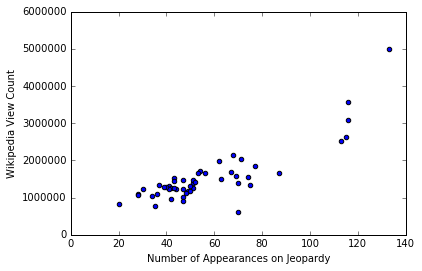

In [37]:
# Create plot again.
ax = state_data.plot(x = 'total_count', y = 'wiki_views', kind = 'scatter')
ax.set_xlabel('Number of Appearances on Jeopardy')
ax.set_ylabel('Wikipedia View Count');

The plot looks a little better and the correlation between Wikipedia views and Total Jeopardy appearances is a little tighter now.

Perhaps the difference is that Jeopardy places more importance on the state of New York than Wikipedia users. :) 

### Oklahoma is OK! Oklahoma City isn't confused with the state of Oklahoma.

Another state with a possibly confusing city name is Oklahoma City; like New York City, it is also the most populous city in the state. However, Oklahoma City doesn't have the same problems as New York City. Unlike New York, for Oklahoma state, the questions where "city" is mentioned in the question all refer to another city in the state of Oklahoma, rather than Oklahoma City.

In [38]:
# Here are the questions where Oklahoma is the answer and "city" is mentioned in the question.
df[(df['answer']=='Oklahoma') & (df['question'].str.contains('city'))]

,air_date,answer,category,question,round,show_number,value
115027,2010-09-21,Oklahoma,WOMEN ON THE MAP,"The city of Enid in this state is believed to be named for a character in ""Idylls of the King""",Jeopardy!,5982,800.0
127770,2010-11-15,Oklahoma,STATE FACTS,The city of Tahlequah in this state is the capital of the Cherokee Nation,Jeopardy!,6021,1000.0


## What have we learned?

The popularity of Jeopardy questions about U.S. states isn't tracked very well by Wikipedia article word counts. However, **U.S. state popularity does correlate well with Wikipedia page views**. It might be interesting to look into this popularity correlation for other broad topics, like countries of the world or animals. 

Another interesting application would be to use this method to *predict* topics that could appear in pop culture or current event categories on Jeopardy. A future contestant might study up on the content in recent, popular wikipedia articles in preparation for an appearance on Jeopardy. Unfortunately, with my current dataset I can't test this hypothesis because the dates don't overlap. My dataset runs from 1997-2000 and 2004-2011 and the Wikipedia API only goes back to around 2015. However, the 2015 Jeopardy data *is [available](http://www.j-archive.com/)* for intrepid webscrapers.